## outline & summary

- q-learning => DQN（Deep Q Learning network)
- q_learning base q-table
    - state 需要是/处理成离散的（discrete）
    - q-table：行是state，列是action；
    - $Q(s,a)$：动作价值（value），不是概率分布；
        - $Q(s_t,a_t)$是在时刻 $t$，状态 $s_t$下采取动作 $a_t$ 时获得的折扣奖励总和（discounted total reward）
            - 未来的价值折现到现在；
    - image（pixels） as a state，状态变量的数量非常之大；
- dqn：nn(state) => action value，
    - q table => q function（**拟合/回归**，state vector 与 action value 的关系） 
    - 输入输出：
        - 输入（input）：state vector;
            - cartpole：4d vector（位置，速度，角度，和角速度），甚至都需要care其semantic meaning；
        - 输出：action space value，$Q(s_t,a_t)$
            - shape：action space size；
            - CartPole：2d（left/right）

## DQN

$$
\begin{split}
&Q(s_t,a_t) = Q(s_t,a_t) + \eta\cdot (R_{t+1}+\gamma \max_a Q(s_{t+1},a)-Q(s_t,a_t))\\
&Q(s_t,a_t) = R_{t+1}+\gamma\cdot \max_aQ(s_{t+1},a)
\end{split}
$$

- iteration algorithm
- temporal difference error（TD）: $R_{t+1}+\gamma\cdot \max_aQ(s_t,a) - Q(s_t,a_t)$
- learning objective：
    - MES（square loss）: $E(s_t,a_t)=\left(R_{t+1}+\gamma\max_aQ(s_{t+1},a)-Q(s_t,a_t)\right)^2$

### 几个核心技术

- experience replay（经验回放）
    - 不像 q-table 的 q-learning，每一步都学习（update）该步的内容（experience）
        - 对于 q-table 而言，每一步（step）都学习该步的内容，神经网络连续地学习时间上相关性高的内容（事实上，时间 $t$ 的学习内容，和时间 $t+1$ 的学习内容非常相似，这样的话，收敛就会很慢；
    - 而是将每一步（step）的内容存储在经验池（experience pool）并随机从经验池中提取内容（replay，回放）让NN学习；
        - 也是一种批次化（batch），使用经验池中的多个步骤的经验；

- loss function 使用 huber 而不是 square loss
    - 误差很大时（$|\delta|>1$），平方误差会导致误差函数的输出过大，导致学习难以稳定

$$
\mathcal L(\delta)=\begin{cases}
\frac12\delta^2,  &\quad |\delta|\leq 1,\\
|\delta|-\frac12, &\quad |\delta|\gt 1
\end{cases}
$$

In [1]:
from IPython.display import Image

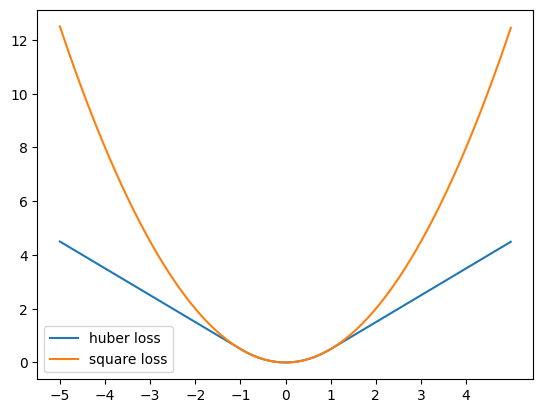

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def huber_loss(delta, beta=1):
    if np.abs(delta) <= beta:
        return 0.5*delta**2/beta
    return abs(delta) - 0.5*beta

def square_loss(delta):
    return 0.5*delta**2

deltas = np.arange(-5, 5, 0.01)
plt.plot(deltas, [huber_loss(delta) for delta in deltas])
plt.plot(deltas, square_loss(deltas))
plt.xticks(np.arange(-5, 5, step=1))
plt.legend(['huber loss', 'square loss'])

[DQN官方文档](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [3]:
import gymnasium as gym
import math 
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available else "cpu")



In [4]:
#经验放回-------------------------------------------------
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)  # 双端队列

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# 自动丢弃最旧的样本
```python
M = ReplayMemory(capacity=3)
M.push(1, 1, 2, 0)
M.push(2, 0, 3, 1)
M.push(3, 1, 4, 0)
print(list(M.memory))   # 3 条记录
M.push(4, 1, 5, 0)      # 第 4 条，容量超限
print(list(M.memory))   # 只剩最新的 3 条，最旧的第 1 条已被自动踢出

output:
[Transition(state=1, action=1, next_state=2, reward=0), Transition(state=2, action=0, next_state=3, reward=1), Transition(state=3, action=1, next_state=4, reward=0)]

[Transition(state=2, action=0, next_state=3, reward=1), Transition(state=3, action=1, next_state=4, reward=0), Transition(state=4, action=1, next_state=5, reward=0)]
```

In [5]:
# Q-network------------------------------------------
class DQN(nn.Module):
    def __init__(self, n_observation, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observation, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

超参数设置

In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500  # 数值越高衰减越慢
TAU = 0.005
LR = 3e-4



In [7]:
# 从 action_space 获取 gym 的 action 数，以及 state observation 
n_actions = env.action_space.n
state, info = env.reset()
n_observation = len(state)

In [8]:
policy_net = DQN(n_observation, n_actions).to(device)
target_net = DQN(n_observation, n_actions).to(device)
# 同步权重，后续柔软更新或格几步让target追赶policy
target_net.load_state_dict(policy_net.state_dict())   

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random() #随机 or 贪心

    # 计算当前的epsilon（探索率） 
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # 选择动作
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            q_values = policy_net(state)     # 网络输出形状 [1, n_actions]
            action = q_values.max(1).indices # 每行最大值的索引 → 最优动作
            return action.view(1, 1)         # 保持形状 [1, 1]，方便后续拼接
    else:
        return torch.tensor([[env.action_space.sample()]],  ##->均匀选择
                            device=device, dtype=torch.long)
    

In [9]:
episode_durations = []

#画图函数
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

optimize_model 把 32 条经验打包成大张量 → 计算当前 Q 与目标 Q → 用 SmoothL1Loss 训练 policy_net，

同时用 target_net 提供稳定目标，整个过程所有形状都在 [bath_size, len(non_final_next_states)] 的 batch 级别完成。

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return  # 放回样本数< batch_size不更新，放置随机采样报错
    
    transitions = memory.sample(BATCH_SIZE) 
    # 从memory=replaymemory(10000)采样batch_size条
    # transitions == [T0, T1, ..., T31]  # list(Transition)

    batch = Transition(*zip(*transitions))
    #转置  zip(*...) 负责“行列互换”。
    # batch.state     -> [s0, s1, ..., s_b]  # list of [4]
    # batch.action    -> [a0, a1, ..., a_b]  # list of [1]
    # batch.reward    -> [r0, r1, ..., r_b]  # list of [1]
    # batch.next_state-> [ns0,...,ns31]      # list of [4] or None

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])  
    # 把非 None 的 next_state 拼接成一个大张量 shpe[batch_size, state]

                                            # shape is：
    state_batch = torch.cat(batch.state)    # [batch_size, state]
    action_batch = torch.cat(batch.action)  # [b, action]
    reward_batch = torch.cat(batch.reward)  # [b]

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) # [b, 2] -> [b ,1]

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values (y = r + gamma * maxQ)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # 这里的action_values shape is [b, 1]

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping (防止梯度爆炸)
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss.item()

Complete


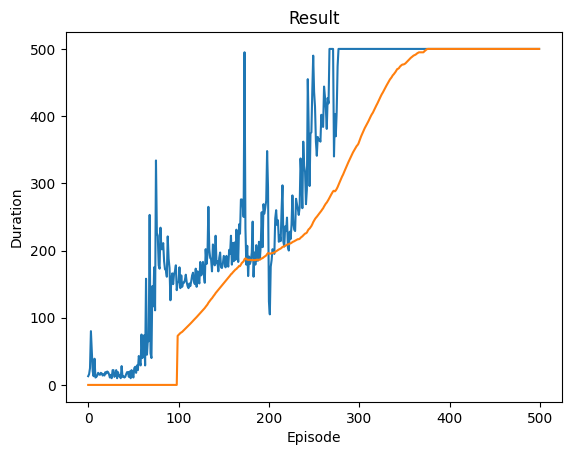

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 500
else:
    num_episodes = 50

# 可选监测
episode_rewards = []
eps_history = []
losses = []
weight_diffs = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    reward_sum = 0.0

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        reward_sum += reward.item()

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model()
        losses.append(loss)

        # Soft update of the target network's weights(软更新权重)
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)


        # 软更新后顺便算权重差异
        # diff = 0
        # for p, t in zip(policy_net.parameters(), target_net.parameters()):
        #     diff += (p - t).abs().sum().item()
        # weight_diffs.append(diff)

        if done:
            episode_rewards.append(reward_sum)  # ← 新增：回合总奖励
            eps_history.append(                      # ← 新增：当前 ε
                EPS_END + (EPS_START - EPS_END) *
                math.exp(-1. * steps_done / EPS_DECAY)
            )
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

稳定达到官方设定的上限500步

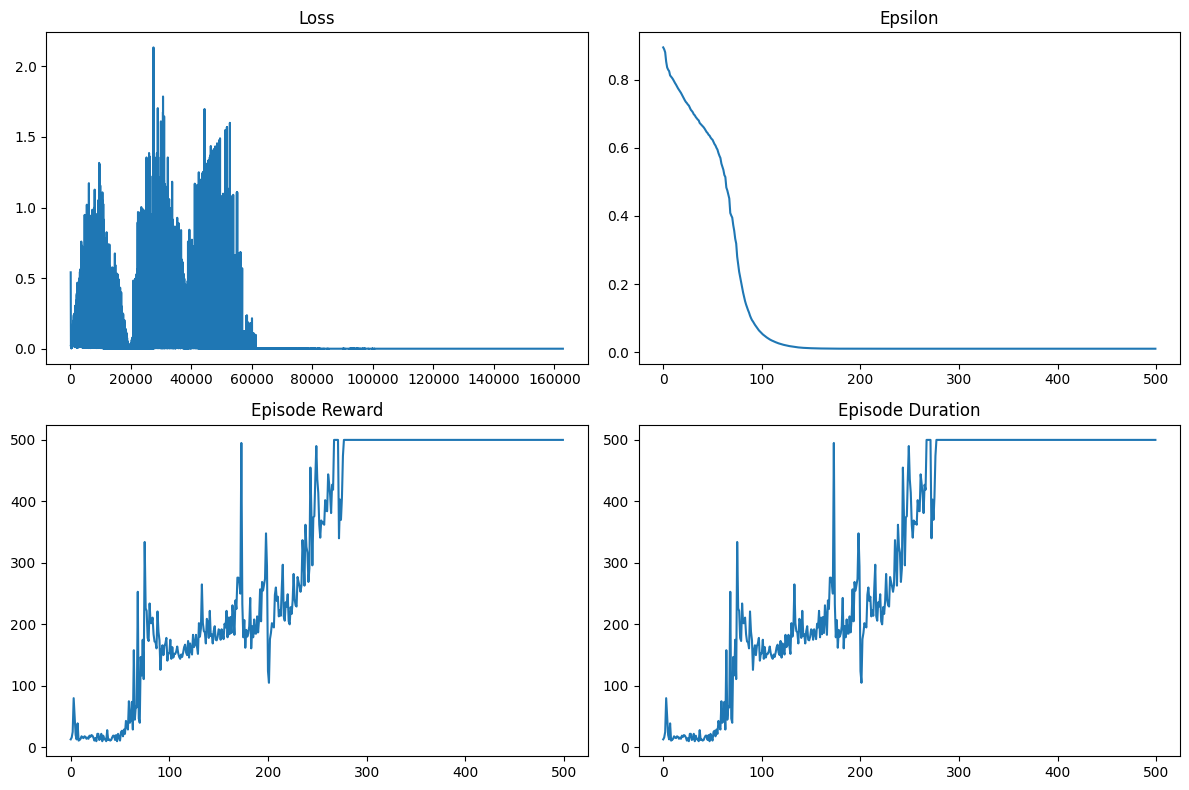

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0,0].plot(losses)
ax[0,0].set_title('Loss')

ax[0,1].plot(eps_history)
ax[0,1].set_title('Epsilon')

ax[1,0].plot(episode_rewards)
ax[1,0].set_title('Episode Reward')

ax[1,1].plot(episode_durations)
ax[1,1].set_title('Episode Duration')

plt.tight_layout()
plt.show()

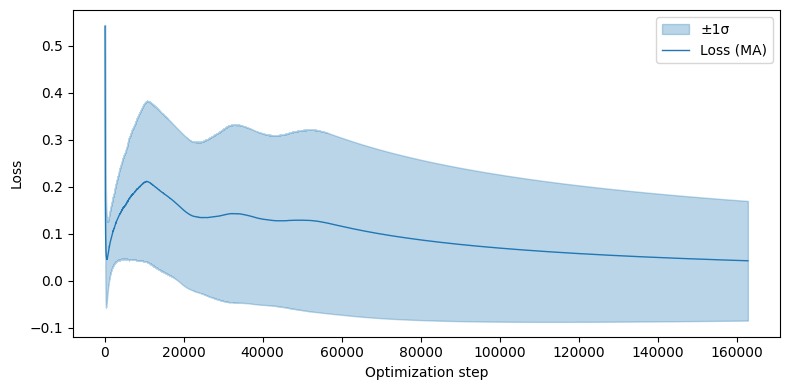

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# losses 长度 = 总优化步数
s = pd.Series(losses)

# 滑动窗口大小根据数据量调，例如 100、500
window = 162805
mean  = s.rolling(window, min_periods=1).mean()
std   = s.rolling(window, min_periods=1).std()

# 画带置信区间
plt.figure(figsize=(8,4))
plt.fill_between(range(len(s)), mean-std, mean+std,
                 color='tab:blue', alpha=0.3, label='±1σ')
plt.plot(mean, color='tab:blue', lw=1, label='Loss (MA)')
plt.xlabel('Optimization step')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
len(losses)

162805